# Plant Disease Identifier

The goal of this notebook is to develop a model to identify plant diseases based on an image

**load the device where we want to make our calculations (CPU or GPU if available)**

In [1]:
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


## 1. Creating the necessary directories

We should already have some directories (root: **"Plant_Disease_Identifier"**), but we will make these modifications:

- Create 3 new directories in **"PlantVillage"** directory: **"train"** to contain the training set / **"val"** to contain the cross-validation set / **"test"** to contain the test set
- **Split** the dataset across the 3 directories (**70%** for the training set, **15%** for the cross-validation set and **15%** for the test set)

First, we need to add the root directory of the project to sys.path so we can import custom modules that we made in the **"src"** directory

In [2]:
import os
import sys

cwd=os.getcwd()

# If cwd doesn't end with "Plant_Disease_Identifier", assume that the project root is the parent folder
if os.path.basename(cwd).lower() != "Plant_Disease_Identifier":
    PROJECT_ROOT = os.path.abspath(os.path.join(cwd, ".."))
else:
    PROJECT_ROOT = cwd

sys.path.insert(0, str(PROJECT_ROOT)) 

We will use the script **"data.py"** from the **"src"** directory as it contains functions that will help us achieve our goals

Now we will call the function that will make us achieve our goal (this may take time)

In [3]:
from src.data import create_directories_and_split_data
create_directories_and_split_data()

We succesfully created our directories. 

## 2. Loading a preexisting model

We will load an already trained image classifier model (**EfficientNet-B1**) and we will train it on our training data

We will Load our model and the transforms using a function in the script **"model.py"**

We will freeze the feature block in the model for now and after we train the output layer we will unfreeze the feature block to fine-tune it

After loading the model we will move it to the **GPU** (if available)

In [4]:
from src.model import create_efficientnetb1_model
model,auto_transform=create_efficientnetb1_model(num_classes=15,fine_tune=False)
model.to(device);

In [5]:
auto_transform

ImageClassification(
    crop_size=[240]
    resize_size=[255]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

## 3. Preparing the data

Now that we have our model and the transformation corresponding to EfficientNet-B1, let's load our data and transform it accordingly

We won't use directly the transform returned by the model on the train set because we want to implement data augmentation (by utilizing the transforms **"RandomResizedCrop"** and **"TrivialAugmentWide"**) to our data so we will make a custom transform while still making sure that our transformation is compatible with **EfficientNet-B1**

For that we will utilize functions in the script **"data.py"**

In [6]:
from src.data import get_dataloader,image_transformation_EfficientNetB1_DataAugmentation

data_transform=image_transformation_EfficientNetB1_DataAugmentation(auto_transform)

TRAIN_DIR=os.path.join(PROJECT_ROOT,"data","PlantVillage","train")
VAL_DIR=os.path.join(PROJECT_ROOT,"data","PlantVillage","val")
TEST_DIR=os.path.join(PROJECT_ROOT,"data","PlantVillage","test")
NUM_WORKERS=os.cpu_count()
BATCH_SIZE=32

train_dataloader=get_dataloader(TRAIN_DIR,data_transform,BATCH_SIZE,True,NUM_WORKERS)
val_dataloader=get_dataloader(VAL_DIR,auto_transform,BATCH_SIZE,False,NUM_WORKERS)
test_dataloader=get_dataloader(TEST_DIR,auto_transform,BATCH_SIZE,False,NUM_WORKERS)


Let's take a look at how the code extracted our classes.

(The returned list from the cell below will be used when coding the Streamlit app that will deploy the model trained in this notebook to make sure that the right order of the classes' names is used)

In [7]:
temp_dataset=train_dataloader.dataset
temp_dataset.classes

['Pepper__bell___Bacterial_spot',
 'Pepper__bell___healthy',
 'Potato___Early_blight',
 'Potato___Late_blight',
 'Potato___healthy',
 'Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato__Target_Spot',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato__Tomato_mosaic_virus',
 'Tomato_healthy']

## 4. Training the model

Let's define our loss function and optimizer

In [38]:
loss_fn=torch.nn.CrossEntropyLoss().to(device)
optimizer=torch.optim.Adam(model.classifier.parameters(),lr=0.001)

We trained the model for 50 epochs and got these results:

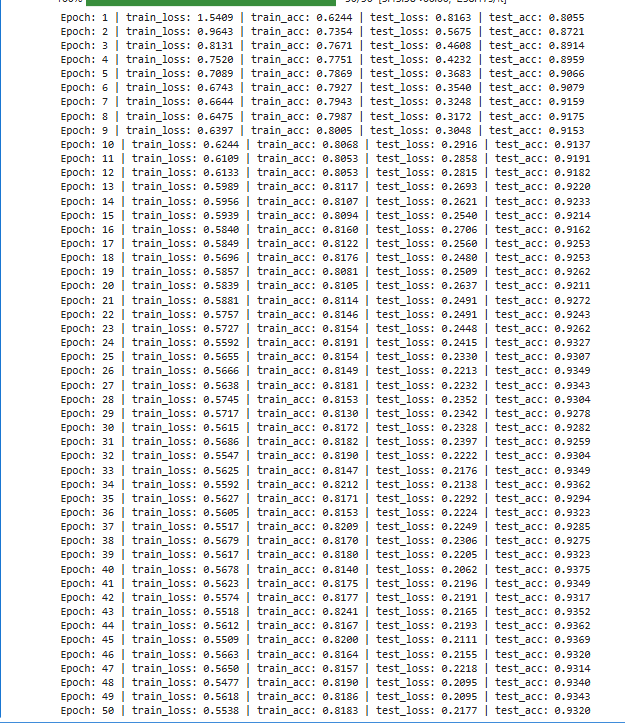

It looks like after 40 epochs of training the validation loss begins to oscillate up and down. That's why we will train the model for only 40 epochs.

We will use the **train()** function from the script **"train.py"** to train the model

In [13]:
from src.train import train

epochs=40
train(model,train_dataloader,val_dataloader,optimizer,loss_fn,epochs,device)

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.5409 | train_acc: 0.6244 | test_loss: 0.8163 | test_acc: 0.8055
Epoch: 2 | train_loss: 0.9643 | train_acc: 0.7354 | test_loss: 0.5675 | test_acc: 0.8721
Epoch: 3 | train_loss: 0.8131 | train_acc: 0.7671 | test_loss: 0.4608 | test_acc: 0.8914
Epoch: 4 | train_loss: 0.7520 | train_acc: 0.7751 | test_loss: 0.4232 | test_acc: 0.8959
Epoch: 5 | train_loss: 0.7089 | train_acc: 0.7869 | test_loss: 0.3683 | test_acc: 0.9066
Epoch: 6 | train_loss: 0.6743 | train_acc: 0.7927 | test_loss: 0.3540 | test_acc: 0.9079
Epoch: 7 | train_loss: 0.6644 | train_acc: 0.7943 | test_loss: 0.3248 | test_acc: 0.9159
Epoch: 8 | train_loss: 0.6475 | train_acc: 0.7987 | test_loss: 0.3172 | test_acc: 0.9175
Epoch: 9 | train_loss: 0.6397 | train_acc: 0.8005 | test_loss: 0.3048 | test_acc: 0.9153
Epoch: 10 | train_loss: 0.6244 | train_acc: 0.8068 | test_loss: 0.2916 | test_acc: 0.9137
Epoch: 11 | train_loss: 0.6109 | train_acc: 0.8053 | test_loss: 0.2858 | test_acc: 0.9191
Epoch: 12 | train_l

Let's save the model

In [23]:
MODEL_PATH=os.path.join(PROJECT_ROOT,"experiments","PlantDiseaseIdentifier.pth")

In [17]:
torch.save(obj = model.state_dict(),f=MODEL_PATH)     # Beware not to overwrite a saved model accidentally 

Now we will fine-tune the whole model so we will unfreeze all layers and re-train the model but with a very small learning rate

In [17]:
for param in model.parameters():
    param.requires_grad = True

In [18]:
optimizer=torch.optim.Adam(model.classifier.parameters(),lr=1e-5)

In [20]:
torch.cuda.empty_cache()      # Empty the cache of the GPU 

epochs=5
train(model,train_dataloader,val_dataloader,optimizer,loss_fn,epochs,device)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.5609 | train_acc: 0.8188 | test_loss: 0.2206 | test_acc: 0.9327
Epoch: 2 | train_loss: 0.5572 | train_acc: 0.8151 | test_loss: 0.2194 | test_acc: 0.9291
Epoch: 3 | train_loss: 0.5501 | train_acc: 0.8243 | test_loss: 0.2151 | test_acc: 0.9362
Epoch: 4 | train_loss: 0.5595 | train_acc: 0.8170 | test_loss: 0.2191 | test_acc: 0.9340
Epoch: 5 | train_loss: 0.5479 | train_acc: 0.8217 | test_loss: 0.2155 | test_acc: 0.9356


Well it appears that this step made the model worse, so we won't save this model

(You may ask yourself why haven't we trained the model for longer, and my answer would be because of hardware limitations)

So let's load our previously saved model

In [24]:
loaded=torch.load(MODEL_PATH)           
model.load_state_dict(loaded)

<All keys matched successfully>

## 5. Testing the model

Now that our model is complete, let's test it on our test set

In [41]:
from src.train import test_step

test_loss,test_acc=test_step(model,test_dataloader,loss_fn,device)
print(f"Test Loss: {test_loss:.4f} | Test Accuracy: {test_acc:.4f}")

That's an impressive accuracy. Now we are certain that our model is ready for deployment.